# RAVDESS Emotional Speech Audio Classification

In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


### Loading RAVDESS Dataset

In [3]:
RAVD = "E:\\Tejas\\data\\audio_speech_actors_01-24\\"

In [4]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)

        
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_disgust        96
male_surprise       96
female_happy        96
female_sad          96
female_angry        96
female_fear         96
female_disgust      96
female_surprise     96
Name: count, dtype: int64

# Data Visualization and Exploration

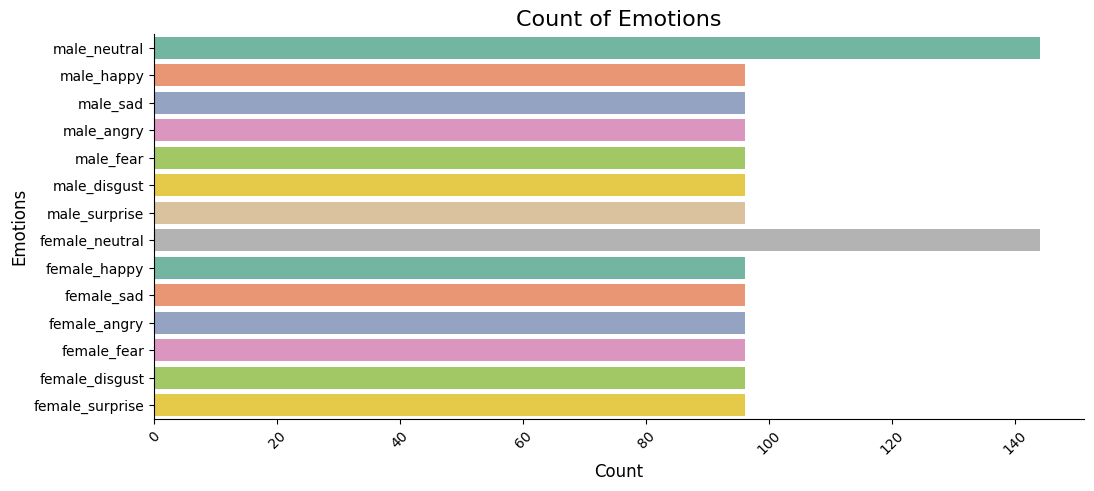

In [5]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels, palette = "Set2")
plt.xlabel('Count', size=12)
plt.ylabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
# Female Happy
fRA1= RAVD + 'Actor_08/03-01-03-02-02-01-08.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 


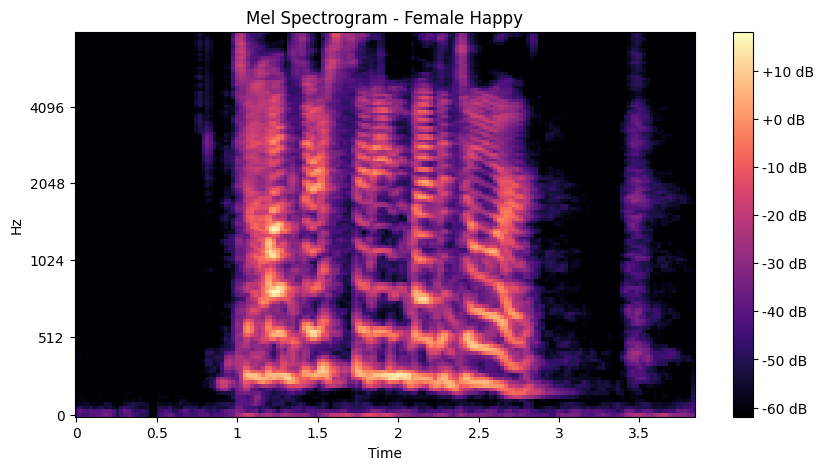

In [7]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')

In [8]:
#Female Fear
fRA2=RAVD +'Actor_08/03-01-06-01-01-01-08.wav'
data, sr = librosa.load(fRA2)
ipd.Audio(fRA2) 

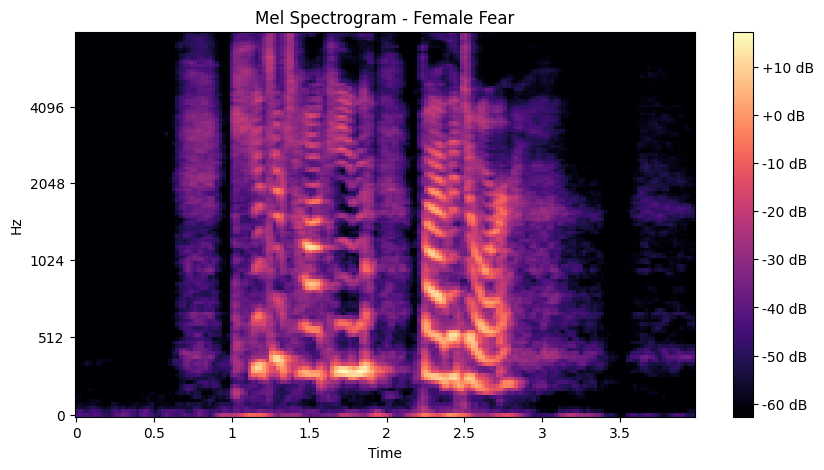

In [9]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fear')
plt.colorbar(format='%+2.0f dB');

In [10]:
# Female Disgust
fRA1 =RAVD +'Actor_20/03-01-08-02-02-02-20.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

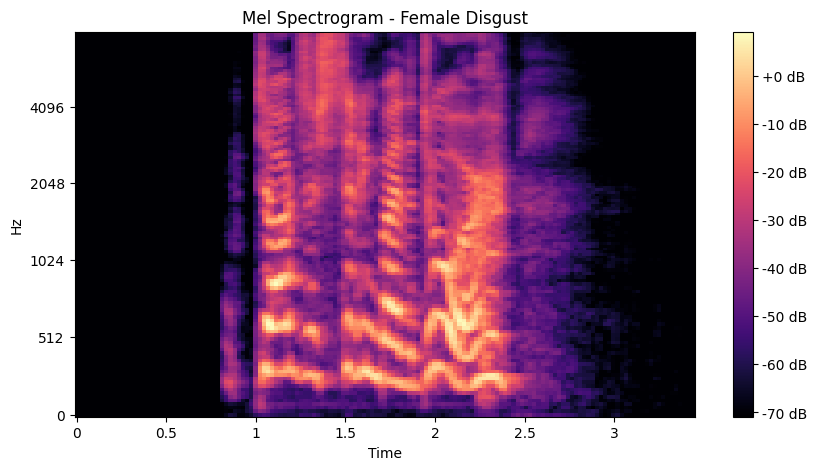

In [11]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Disgust')
plt.colorbar(format='%+2.0f dB');

In [12]:
# Male Fearfull
fRA1 = RAVD + 'Actor_19/03-01-04-01-02-01-19.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

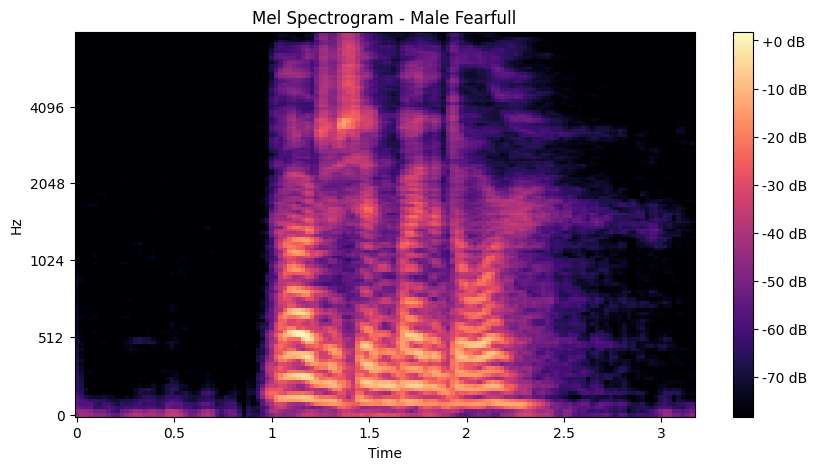

In [13]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Fearfull')
plt.colorbar(format='%+2.0f dB');

# DATA AUGMENTATION

In [14]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, n_steps=pitch_factor, sr=sample_rate)


In [15]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

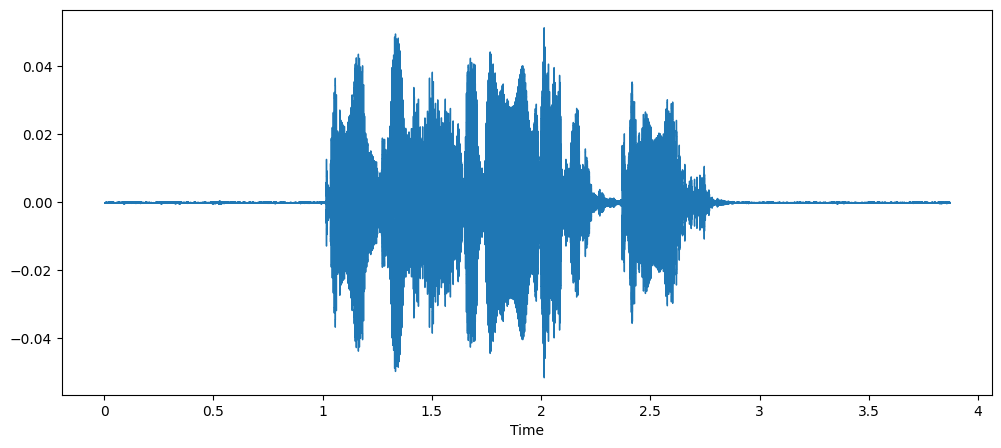

In [16]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

### Noise injection

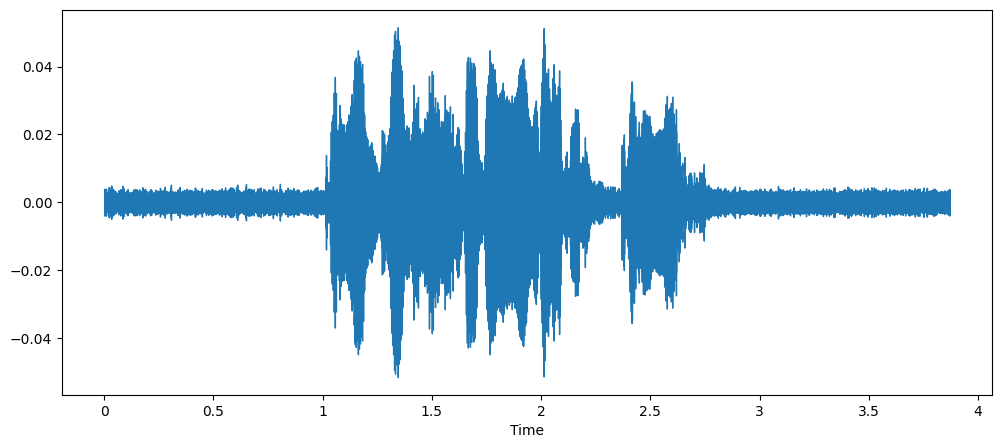

In [17]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Stretching

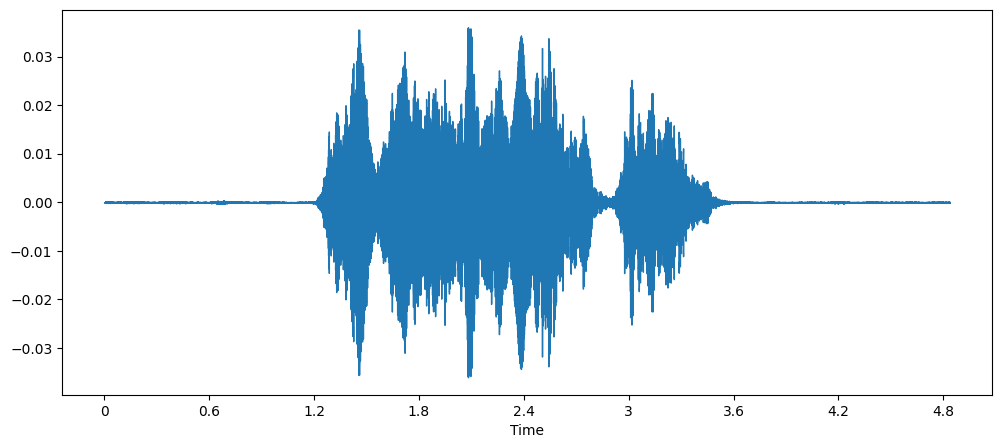

In [18]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Shifting

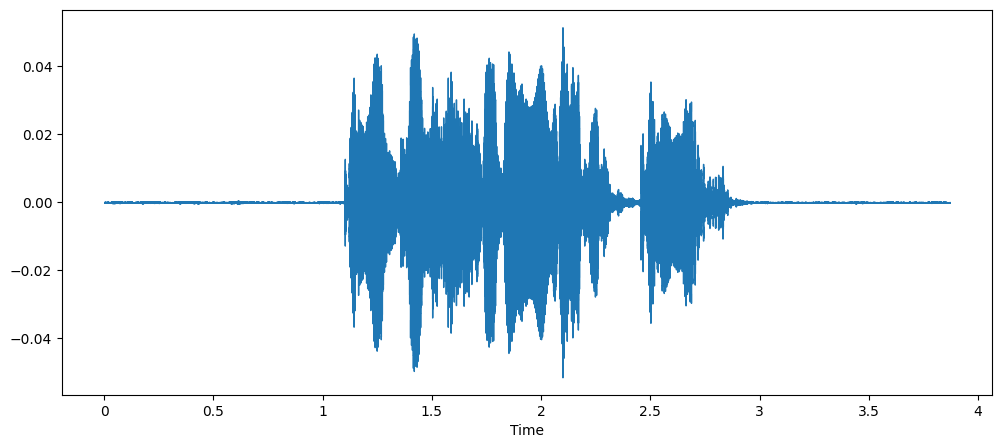

In [19]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Pitch

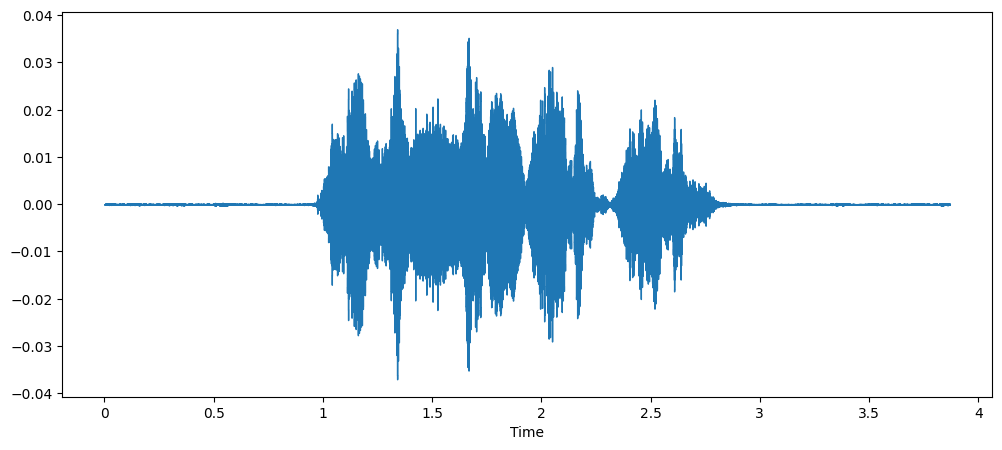

In [20]:
# AUDIO WITH PITCH
x = pitch(data, pitch_factor=0.7)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# FEATURE EXTRACTION

In [21]:

def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, pitch_factor=0.7)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [22]:
RAVD_df.head()

labels   source                                               path
0  male_neutral  RAVDESS  E:\Tejas\data\audio_speech_actors_01-24\Actor_...
1  male_neutral  RAVDESS  E:\Tejas\data\audio_speech_actors_01-24\Actor_...
2  male_neutral  RAVDESS  E:\Tejas\data\audio_speech_actors_01-24\Actor_...
3  male_neutral  RAVDESS  E:\Tejas\data\audio_speech_actors_01-24\Actor_...
4  male_neutral  RAVDESS  E:\Tejas\data\audio_speech_actors_01-24\Actor_...

In [23]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [24]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

0          1         2          3          4         5         6  \
0 -645.880737  72.619637  0.841306  16.399446  10.241593  0.653901 -4.328001   
1 -452.529403  32.307976  7.714264   8.971588   5.315544 -0.122344 -3.162142   
2 -712.554138  70.982567 -0.730791  16.815756   7.991097 -0.822035 -6.391328   
3 -634.663269  72.324066 -2.998578  20.209740  10.674218 -1.151011 -2.813592   
4 -416.594893  24.465656  9.628968  10.360223   5.472558 -0.110936 -2.329527   

          7          8         9  ...        11        12        13        14  \
0 -4.258932 -14.575824 -3.806285  ... -4.042665  2.519602 -4.972247  0.566447   
1 -7.246969  -9.757926 -6.083207  ... -1.574733 -1.597033 -1.880756 -0.659795   
2 -6.146841 -15.975542 -0.313774  ... -3.398325  2.348432 -6.031354  1.242991   
3 -7.923956 -16.231958 -2.627547  ... -4.167823  0.719305 -4.954944 -0.688254   
4 -6.375159  -7.959599 -4.887991  ... -2.179670 -1.906795 -2.407362 -1.372822   

         15        16        17        18        19        labels  
0  1.035527 -5.416451 -2.449469 -1.782306 -1.212806  male_neutral  
1 -0.426354 -3.704906 -3.049010  0.324266 -2.713384  male_neutral  
2 -1.837347 -5.671209 -3.115795 -1.071987 -4.964169  male_neutral  
3  0.114427 -6.475232 -1.695712 -2.899729  0.377746  male_neutral  
4 -0.628752 -2.899114 -2.468834 -0.396719 -2.164856  male_neutral  

[5 rows x 21 columns]

In [25]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

0          1         2          3          4         5         6  \
0 -645.880737  72.619637  0.841306  16.399446  10.241593  0.653901 -4.328001   
1 -452.529403  32.307976  7.714264   8.971588   5.315544 -0.122344 -3.162142   
2 -712.554138  70.982567 -0.730791  16.815756   7.991097 -0.822035 -6.391328   
3 -634.663269  72.324066 -2.998578  20.209740  10.674218 -1.151011 -2.813592   
4 -416.594893  24.465656  9.628968  10.360223   5.472558 -0.110936 -2.329527   

          7          8         9  ...        11        12        13        14  \
0 -4.258932 -14.575824 -3.806285  ... -4.042665  2.519602 -4.972247  0.566447   
1 -7.246969  -9.757926 -6.083207  ... -1.574733 -1.597033 -1.880756 -0.659795   
2 -6.146841 -15.975542 -0.313774  ... -3.398325  2.348432 -6.031354  1.242991   
3 -7.923956 -16.231958 -2.627547  ... -4.167823  0.719305 -4.954944 -0.688254   
4 -6.375159  -7.959599 -4.887991  ... -2.179670 -1.906795 -2.407362 -1.372822   

         15        16        17        18        19        labels  
0  1.035527 -5.416451 -2.449469 -1.782306 -1.212806  male_neutral  
1 -0.426354 -3.704906 -3.049010  0.324266 -2.713384  male_neutral  
2 -1.837347 -5.671209 -3.115795 -1.071987 -4.964169  male_neutral  
3  0.114427 -6.475232 -1.695712 -2.899729  0.377746  male_neutral  
4 -0.628752 -2.899114 -2.468834 -0.396719 -2.164856  male_neutral  

[5 rows x 21 columns]

### DATA PREPROCESSING

In [26]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [27]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [28]:
# Train and Test Split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

In [29]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

### Using CNN for Speech Recognition

In [30]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 14), (1080, 20, 1), (1080, 14))

In [31]:
#CNN
import tensorflow as tf 
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 10, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                        

In [32]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
51/51 [==============================] - 96s 2s/step - loss: 2.6083 - accuracy: 0.0898 - val_loss: 2.6339 - val_accuracy: 0.0704
Epoch 2/150
51/51 [==============================] - 89s 2s/step - loss: 2.5588 - accuracy: 0.1130 - val_loss: 2.6279 - val_accuracy: 0.0611
Epoch 3/150
51/51 [==============================] - 90s 2s/step - loss: 2.5032 - accuracy: 0.1410 - val_loss: 2.6182 - val_accuracy: 0.0963
Epoch 4/150
51/51 [==============================] - 90s 2s/step - loss: 2.4670 - accuracy: 0.1627 - val_loss: 2.6077 - val_accuracy: 0.0778
Epoch 5/150
51/51 [==============================] - 91s 2s/step - loss: 2.4096 - accuracy: 0.1858 - val_loss: 2.6039 - val_accuracy: 0.0444
Epoch 6/150
51/51 [==============================] - 94s 2s/step - loss: 2.3436 - accuracy: 0.2123 - val_loss: 2.5609 - val_accuracy: 0.1426
Epoch 7/150
51/51 [==============================] - 94s 2s/step - loss: 2.2621 - accuracy: 0.2367 - val_loss: 2.5269 - val_accuracy: 0.2028
Epoch 8/150
5

In [33]:
#CNN
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

34/34 [==============================] - 1s 40ms/step - loss: 1.3541 - accuracy: 0.8426
Accuracy of our model on test data :  84.25925970077515 %


In [35]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(15)

34/34 [==============================] - 2s 39ms/step


Predicted Labels    Actual Labels
0       female_fear      female_fear
1        male_angry       male_angry
2        female_sad      female_fear
3    female_neutral   female_neutral
4      female_angry     female_angry
5   female_surprise  female_surprise
6          male_sad        male_fear
7        male_happy       male_happy
8       female_fear      female_fear
9          male_sad         male_sad
10     male_disgust     male_disgust
11   female_neutral   female_neutral
12       male_angry       male_angry
13     female_angry     female_angry
14     male_disgust     male_disgust

### Confusion Matrix Using CNN

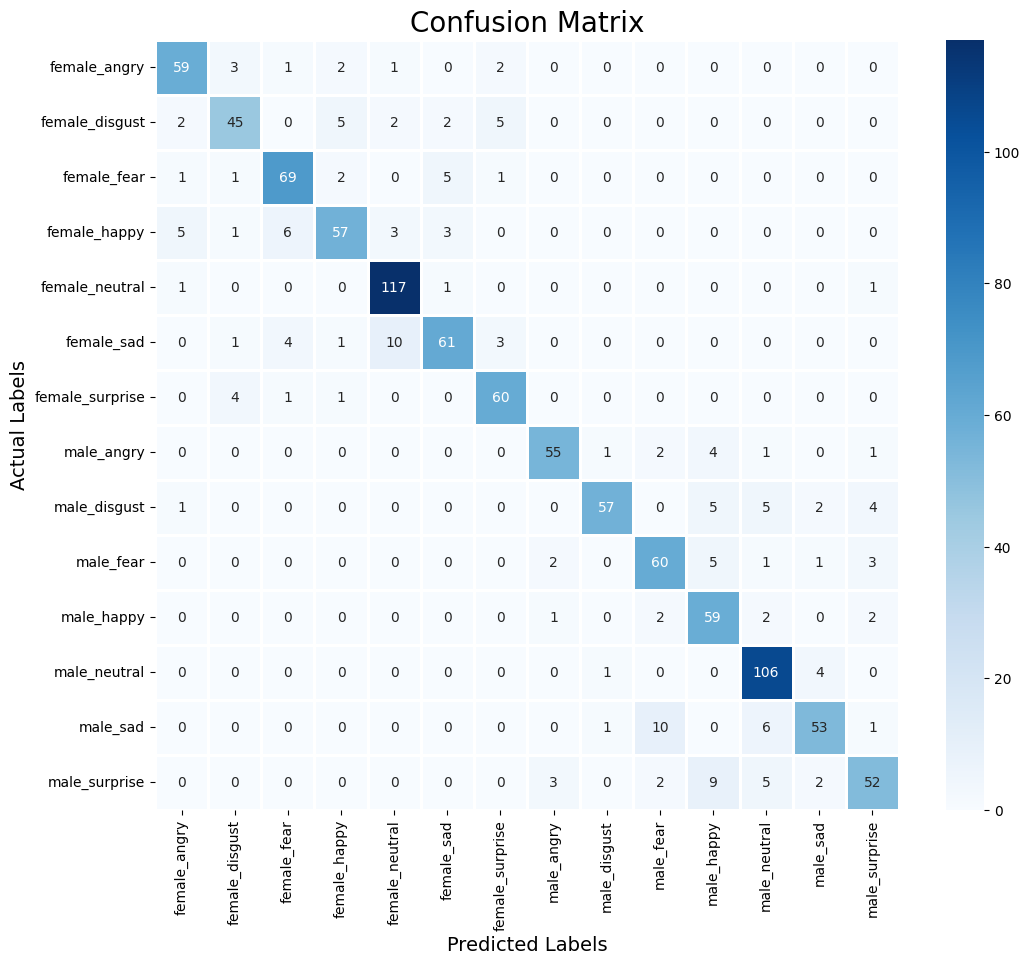

In [36]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

### Classification Report Using CNN

In [37]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.86      0.87      0.86        68
 female_disgust       0.82      0.74      0.78        61
    female_fear       0.85      0.87      0.86        79
   female_happy       0.84      0.76      0.80        75
 female_neutral       0.88      0.97      0.92       120
     female_sad       0.85      0.76      0.80        80
female_surprise       0.85      0.91      0.88        66
     male_angry       0.90      0.86      0.88        64
   male_disgust       0.95      0.77      0.85        74
      male_fear       0.79      0.83      0.81        72
     male_happy       0.72      0.89      0.80        66
   male_neutral       0.84      0.95      0.89       111
       male_sad       0.85      0.75      0.80        71
  male_surprise       0.81      0.71      0.76        73

       accuracy                           0.84      1080
      macro avg       0.84      0.83      0.83      1080
   weighted avg       0.85   

##### After completing the all training part we got good accuracy using CNN so we plot the confusion matrix and classification report.